In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../../astro_codes/')

In [2]:
# Load the *sparcfire* data
import pandas as pd
sparcfire_r = Table.read('../../sparcfire_directories/r/r.galaxy_matched.fits')
sparcfire_r_arcs = pd.read_csv('../../sparcfire_directories/r/r.galaxy_arcs.csv')

In [3]:
from combining_catalogues import match_ids, make_matched_catalogue

spotter_subjects = Table.read('../../SpiralSpotter/tables/spiral_spotter_sparcfire_subjects.fits')
spotter_data = Table.read('../../SpiralSpotter/tables/spiral_spotter_sparcfire_data.fits')

matched_rows = match_ids(spotter_subjects,spotter_data,
                         'subject_id','subject_id')

matched_data = make_matched_catalogue(spotter_subjects,spotter_data,
                                      matched_rows)

matched_data['dr7id'] = spotter_subjects['dr7objid']
matched_data['dr8id'] = spotter_subjects['dr8objid']
matched_data.write('spotter_subjects_matched.fits',overwrite=True)
spotter_data = matched_data.copy()

500 galaxies in the reference catalogue
468 galaxies in the match catalogue
---> 457 matches in total


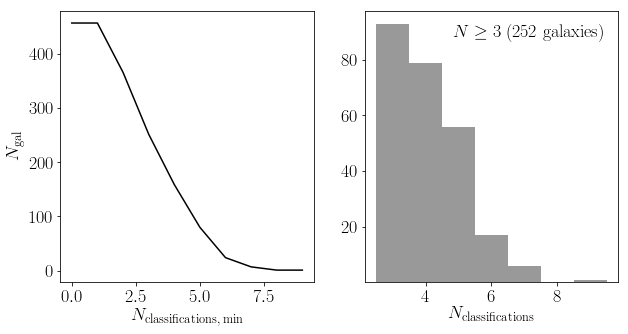

In [4]:
N_ok = []
N_classifications = []

for N in range(10):
    N_ok.append((spotter_data['total'] >= N).sum())
    N_classifications.append(N)

fig, axarr = plt.subplots(1,2,figsize=(10,5))
plt.sca(axarr[0])
_ = plt.plot(N_classifications,N_ok,color='k')
_ = plt.xlabel('$N_\mathrm{classifications, \, min}$')
_ = plt.ylabel('$N_\mathrm{gal}$')

class_ok = spotter_data['total'] >= 3
plt.sca(axarr[1])
_ = plt.hist(spotter_data['total'][class_ok],bins=np.linspace(2.5,9.5,8),
             color='k',alpha=0.4)
_ = plt.xlabel('$N_\mathrm{classifications}$')
_ = plt.text(0.95,0.95,'$N \geq{}$ ({} galaxies)'.format(3,class_ok.sum()),
             transform=axarr[1].transAxes,ha='right',va='top')

spotted_ids = spotter_data['dr8id'][class_ok]
spotter_data['class_ok'] = class_ok

In [5]:
from arc_data import ArcData, ParamikoClient

arc_tables = []
for id_ in spotted_ids:
    arc_tables.append(ArcData(id_).arc_parameters(sparcfire_r_arcs,
                                                   sparcfire_r))
    
arc_table_spotted = vstack(arc_tables)

In [15]:
def match_arc_scores(arc_table,galaxy_table,
                     arc_id='gxyName',galaxy_id='dr8id'):
    labels = ('good','poor','weak','extension','junk','missing')
    ids = np.unique(arc_table['gxyName'])
    N_arc_rows = len(arc_table)
    arc_table['total'] = np.zeros(N_arc_rows,dtype=np.int)
    for label in labels:
        arc_table['p_{}'.format(label)] = np.zeros(N_arc_rows,
                                                   dtype=np.float16)
    for id_ in ids: 
        masked_arc_rows = arc_table[arc_id] == id_
        masked_galaxy_row = galaxy_table[galaxy_id] == id_
        arc_rows = arc_table[masked_arc_rows]
        galaxy_row = galaxy_table[masked_galaxy_row]
        N_arcs = masked_arc_rows.sum()
        
        for label in labels:
            column_values = []
            for n in range(N_arcs):
                column_name = 'arc{}_{}_frac'.format(n+1,label)
                arc_column_name = 'p_{}'.format(label)
                column_values.append(galaxy_row[column_name][0])
            arc_table[arc_column_name][masked_arc_rows] = column_values
        arc_table['total'][masked_arc_rows] = galaxy_table[masked_galaxy_row]['total']
            
    return arc_table

arc_table_spotted = match_arc_scores(arc_table_spotted,spotter_data)
# ^ this table is a table of 'spotted' galaxies with their corresponding 
# arc p-values from SpiralSpotter

In [61]:
columns = ('p_good','p_poor','p_weak','p_extension','p_junk','p_missing')
N_clicks = []

for column in columns:
    clicks = arc_table_spotted[column]*arc_table_spotted['total']
    clicks = np.round(clicks,decimals=0).astype(np.int)
    N_clicks.append(clicks.sum())
    
N_clicks = np.array(N_clicks)

In [65]:
class_column = ['good','poor','weak','extension','junk','missing']

array([1088,  298,  713,  669, 1175, 2673])

In [81]:
N_arcs = len(arc_table_spotted)
arc_array = np.zeros((N_arcs,6))

for c, column in enumerate(columns):
    arc_array[:,c] = arc_table_spotted[column]
    
max_list = np.max(arc_array,axis=1)
duplicate_max = []
for m, max_ in enumerate(max_list):
    N_max = np.sum(arc_array[m] == max_)
    duplicate_max.append(N_max > 1)
duplicate_max = np.array(duplicate_max)
arc_class = np.argmax(arc_array,axis=1) + 1
arc_class[duplicate_max] = 0

In [98]:
from tabulate import tabulate

click_strings = ['{} ({}%)'.format(N_clicks[c],np.round(100*N_clicks[c]/N_clicks.sum(),decimals=1)) 
                 for c in range(6)]

class_strings = ['{} ({}%)'.format((arc_class == c+1).sum(),
                                   np.round(100*(arc_class == c+1).sum()/len(arc_class),decimals=1))
                for c in range(6)]

print_array = np.array([columns,click_strings,class_strings]).T


In [105]:
spotter_print_table = tabulate(print_array,
                headers=('class','N_\mathrm{clicks}','N_\mathrm{arcs}'),
                               tablefmt='latex')

In [106]:
print(spotter_print_table)

\begin{tabular}{lll}
\hline
 class       & N\_\textbackslash{}mathrm\{clicks\}   & N\_\textbackslash{}mathrm\{arcs\}   \\
\hline
 p\_good      & 1088 (16.4\%)        & 244 (15.1\%)       \\
 p\_poor      & 298 (4.5\%)          & 17 (1.1\%)         \\
 p\_weak      & 713 (10.8\%)         & 85 (5.3\%)         \\
 p\_extension & 669 (10.1\%)         & 104 (6.4\%)        \\
 p\_junk      & 1175 (17.8\%)        & 190 (11.8\%)       \\
 p\_missing   & 2673 (40.4\%)        & 678 (41.9\%)       \\
\hline
\end{tabular}
